# **DCGAN to generate music**

**Imports**

In [0]:
from keras import layers
from keras import optimizers
from keras import models
from keras.layers.advanced_activations import LeakyReLU
from keras.datasets import mnist

import matplotlib.pyplot as plt
import numpy as np

Using TensorFlow backend.


In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
fileIDs = ['1YaKVN4Es5MTZAOHBZZ1XWDR8mDHTTJnc', '1flTx5t_5YnUwY_LsKAfkrQoE6uVv78ay']

for fileID in fileIDs:
  downloaded = drive.CreateFile({'id': fileID})
  print('Downloading file "{}"'.format(downloaded['title']))
  downloaded.GetContentFile(downloaded['title'])
  print("Download Complete - {}".format(downloaded['title']))

    100% |████████████████████████████████| 993kB 13.8MB/s 
Download Complete - Major_Tunes_Notes.npy
Download Complete - Major_Tunes_Time.npy


**Import numpy array**

In [0]:
notes = np.load("Major_Tunes_Notes.npy")
print("Loaded data")
print("Shape: {}".format(notes.shape))
print("First Entry:", end="\n\n")
print(notes[0:1], end="\n\n")

time = np.load("Major_Tunes_Time.npy")
print("Loaded Time Array")
print("Shape: {}".format(time.shape))
print("First Entry:", end="\n\n")
print(time[0:1], end="\n\n")

Loaded data
Shape: (6142,)
First Entry:

[array([[64, 64, 64, 64,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2],
       [66, 66, 73, 73, 73, 73, 71, 71, 73, 73, 73, 73, 66, 66, 73, 73],
       [73, 73, 73, 73, 71, 71, 73, 73, 76, 76, 73, 73, 71, 71, 69, 69],
       [68, 68, 64, 64, 71, 71, 64, 64, 73, 73, 64, 64, 71, 71, 64, 64],
       [68, 68, 64, 64, 71, 71, 64, 64, 76, 76, 71, 71, 68, 68, 64, 64],
       [66, 66, 73, 73, 73, 73, 71, 71, 73, 73, 73, 73, 66, 66, 73, 73],
       [73, 73, 73, 73, 71, 71, 73, 73, 76, 76, 78, 78, 80, 80, 81, 81],
       [83, 83, 80, 80, 78, 78, 74, 74, 76, 76, 73, 73, 71, 71, 68, 68],
       [64, 64, 66, 66, 68, 68, 64, 64, 66, 66, 66, 66, 64, 64, 64, 64],
       [66, 66, 73, 73, 73, 73, 71, 71, 73, 73, 73, 73, 66, 66, 73, 73],
       [73, 73, 73, 73, 71, 71, 73, 73, 76, 76, 73, 73, 71, 71, 69, 69],
       [68, 68, 64, 64, 71, 71, 64, 64, 73, 73, 64, 64, 71, 71, 64, 64],
       [68, 68, 64, 64, 71, 71, 64, 64, 76, 76, 71, 71, 68, 68, 64, 64],
       [6

**Exclude any tunes that are made of any less than 16 bars or do not have exactly 16 notes per bar**

In [0]:
numOfBars = np.array([tune.shape[0] for tune in notes])
notesPerBar = np.array([tune.shape[1] for tune in notes])
notes = notes[(numOfBars >= 16) & (notesPerBar == 16)]
time = time[(numOfBars >= 16) & (notesPerBar == 16)]

print("New number of tunes: {}".format(notes.shape[0]))

New number of tunes: 6132


**Reshape and Clip To Fixed 4x64 structure**

In [0]:
def reshape_clip(arr):
  print("Old shape: {}".format(arr.shape))
  
  reshaped = np.array([tune[:16] for tune in arr]) #just takes the first 16 bars
  reshaped = reshaped.reshape([-1, 16//4, 16*4]) #stack 4 bars per line
  print("New shape: {}".format(reshaped.shape), end="\n\n")
  
  return reshaped

print("Reshaping the Notes Array")
notes = reshape_clip(notes)

print("Reshaping the Time Array")
time = reshape_clip(time)

Reshaping the Notes Array
Old shape: (6132,)
New shape: (6132, 4, 64)

Reshaping the Time Array
Old shape: (6132,)
New shape: (6132, 4, 64)



**Merge the time and notes into the same n dimensional array**

In [0]:
data = np.stack([notes, time], axis=-1) #makes the time data effectively a new colour channel
print("Merged Shape: {}".format(data.shape))

Merged Shape: (6132, 4, 64, 2)


**Padding Training Data**

In [0]:
paddedData = np.pad(data, [[0,0],[0,1],[4,4], [0,0]], mode='wrap') #pad bottom of image once, and pad left and right with 4 notes

### Normalize Training Data

In [0]:
maxNote = np.percentile(paddedData[:,:,:,0], 95)
minNote = np.percentile(paddedData[:,:,:,0], 5)
print(f"Max Note: {maxNote}\t Min Note: {minNote}")

def normalize(arr, minVal, maxVal):
  return -1 + 2*(arr - minVal)/(maxVal - minVal) #Mapped to [-1,1]

def scale(arr, minVal, maxVal):
  return 0.5*(maxVal-minVal)*(arr+1) + minVal #Map from [-1,1] to [minVal, maxVal]

normalizedData = np.array(paddedData).astype(np.float32)
normalizedData[:,:,:,0] = normalize(normalizedData[:,:,:,0], minNote, maxNote)
timingData = normalizedData[:,:,:,1]
timingData[timingData == 0] = -1

print("Sample note values:")
print(normalizedData[0, :2, :, 0])

Max Note: 80.0	 Min Note: 57.0
Sample note values:
[[ 0.21739125  0.21739125 -0.39130437 -0.39130437 -0.39130437 -0.39130437
  -0.39130437 -0.39130437 -5.7826085  -5.7826085  -5.7826085  -5.7826085
  -5.7826085  -5.7826085  -5.7826085  -5.7826085  -5.7826085  -5.7826085
  -5.7826085  -5.7826085  -0.21739131 -0.21739131  0.39130437  0.39130437
   0.39130437  0.39130437  0.21739125  0.21739125  0.39130437  0.39130437
   0.39130437  0.39130437 -0.21739131 -0.21739131  0.39130437  0.39130437
   0.39130437  0.39130437  0.39130437  0.39130437  0.21739125  0.21739125
   0.39130437  0.39130437  0.6521739   0.6521739   0.39130437  0.39130437
   0.21739125  0.21739125  0.04347825  0.04347825 -0.04347825 -0.04347825
  -0.39130437 -0.39130437  0.21739125  0.21739125 -0.39130437 -0.39130437
   0.39130437  0.39130437 -0.39130437 -0.39130437  0.21739125  0.21739125
  -0.39130437 -0.39130437 -0.39130437 -0.39130437 -0.39130437 -0.39130437]
 [ 0.21739125  0.21739125 -0.04347825 -0.04347825 -0.04347825 

In [0]:
normalizedData = np.expand_dims(normalizedData[:,:,:,0], -1)

**DCGAN**

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 4, 64, 32)         608       
_________________________________________________________________
cropping2d_1 (Cropping2D)    (None, 3, 56, 32)         0         
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 3, 56, 32)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 28, 64)         36928     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 2, 28, 64)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3584)              0         
_________________________________________________________________
dens

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.7240481376647949, acc.: 16.67%] [G loss: 0.513653576374054]
Real: Notes


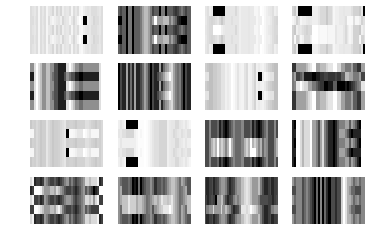

Generated: Notes


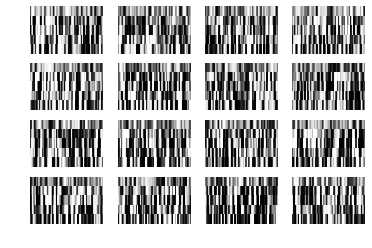

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


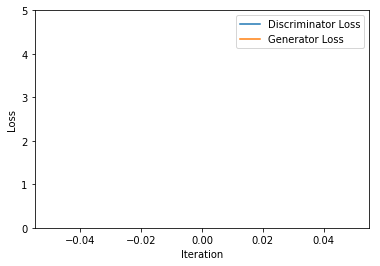

200 [D loss: 0.5840845704078674, acc.: 60.00%] [G loss: 0.8884761929512024]
Real: Notes


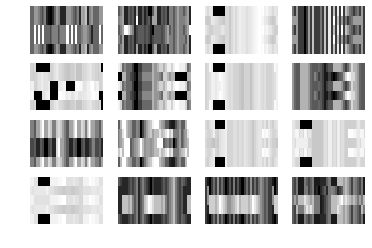

Generated: Notes


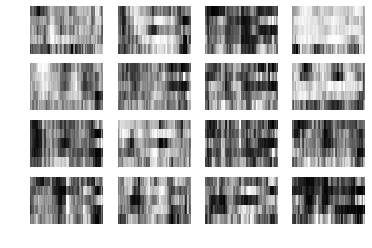

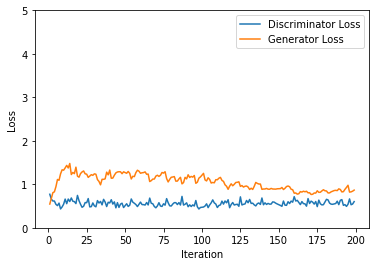

400 [D loss: 0.6037400960922241, acc.: 65.00%] [G loss: 1.037691354751587]
Real: Notes


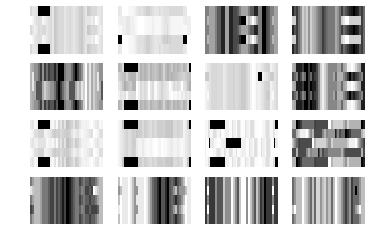

Generated: Notes


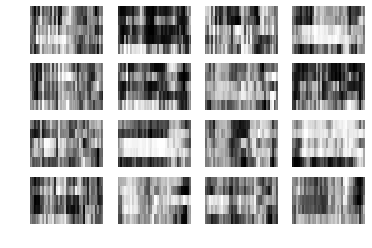

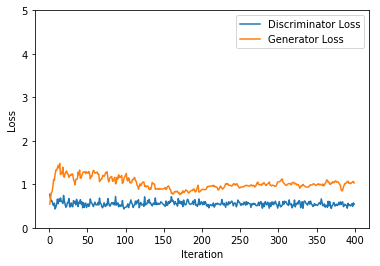

600 [D loss: 0.5361406803131104, acc.: 68.33%] [G loss: 1.0548640489578247]
Real: Notes


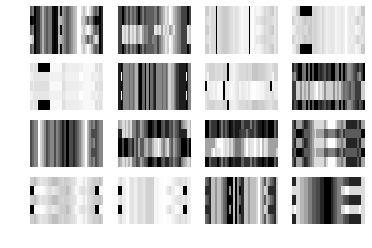

Generated: Notes


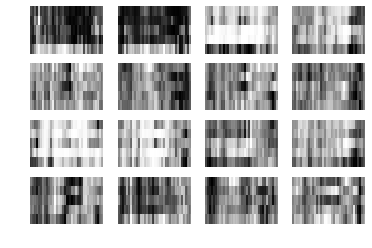

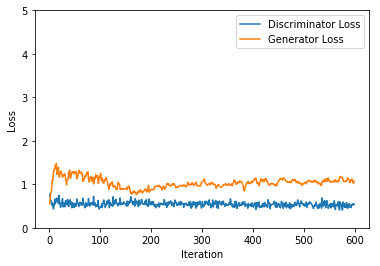

800 [D loss: 0.5715974569320679, acc.: 71.67%] [G loss: 0.9829117059707642]
Real: Notes


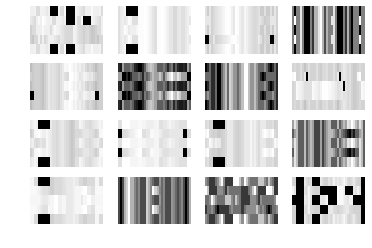

Generated: Notes


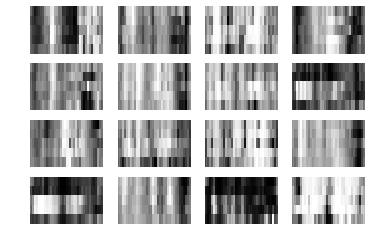

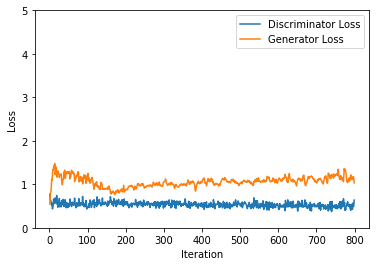

1000 [D loss: 0.3649672269821167, acc.: 83.33%] [G loss: 1.2948731184005737]
Real: Notes


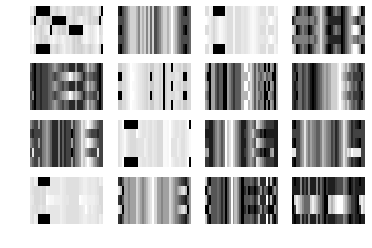

Generated: Notes


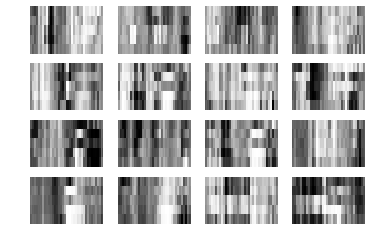

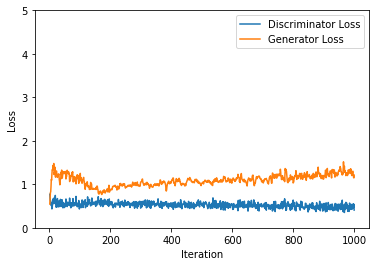

1200 [D loss: 0.49061232805252075, acc.: 76.67%] [G loss: 1.174561619758606]
Real: Notes


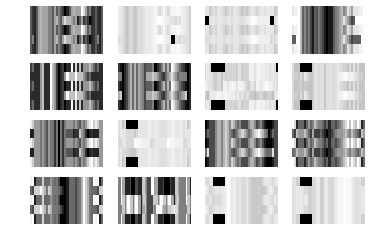

Generated: Notes


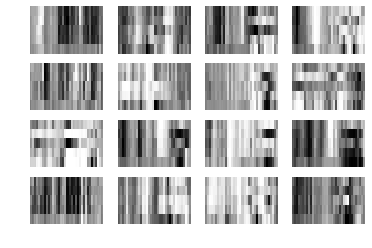

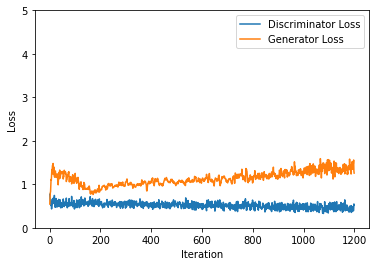

1400 [D loss: 0.3767577111721039, acc.: 83.33%] [G loss: 1.608543872833252]
Real: Notes


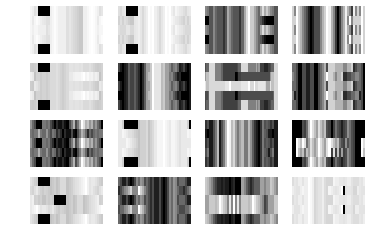

Generated: Notes


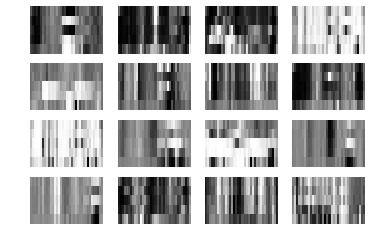

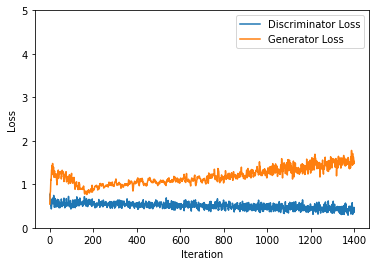

1600 [D loss: 0.42260468006134033, acc.: 81.67%] [G loss: 1.548704981803894]
Real: Notes


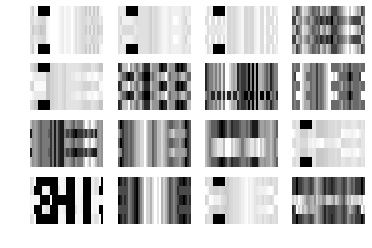

Generated: Notes


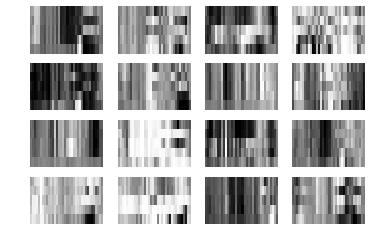

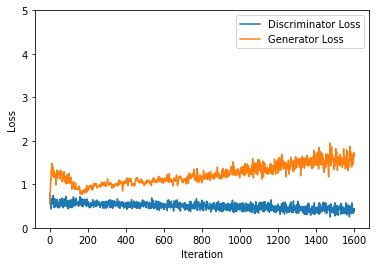

1800 [D loss: 0.5506465435028076, acc.: 73.33%] [G loss: 1.4812835454940796]
Real: Notes


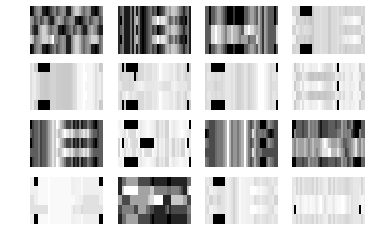

Generated: Notes


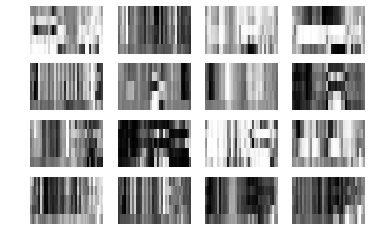

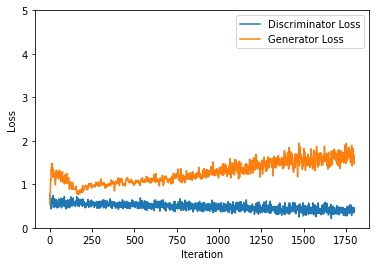

2000 [D loss: 0.4034288227558136, acc.: 83.33%] [G loss: 1.769331455230713]
Real: Notes


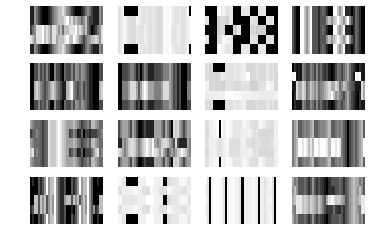

Generated: Notes


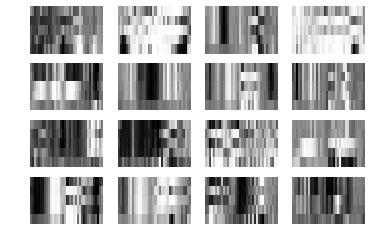

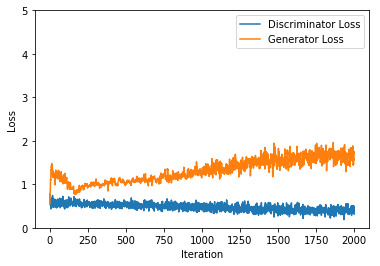

2200 [D loss: 0.4539061188697815, acc.: 76.67%] [G loss: 1.667937994003296]
Real: Notes


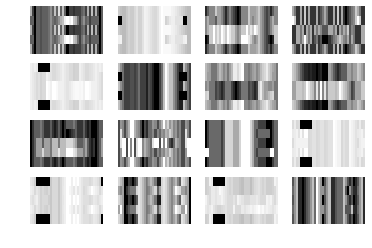

Generated: Notes


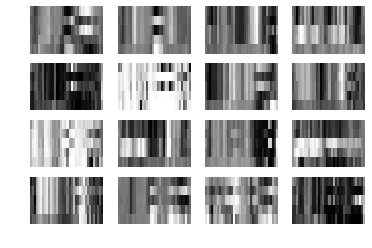

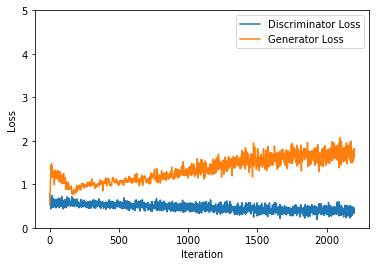

2400 [D loss: 0.4282125234603882, acc.: 83.33%] [G loss: 1.7243098020553589]
Real: Notes


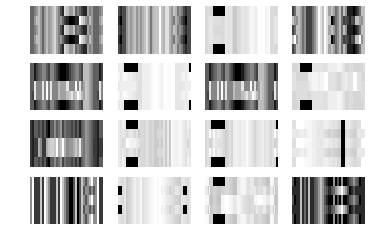

Generated: Notes


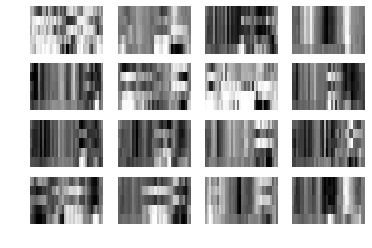

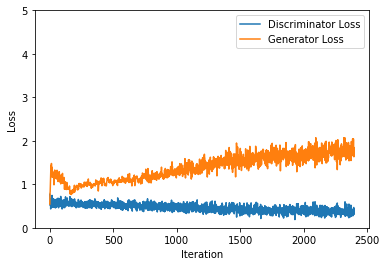

2600 [D loss: 0.3469063639640808, acc.: 83.33%] [G loss: 1.6248443126678467]
Real: Notes


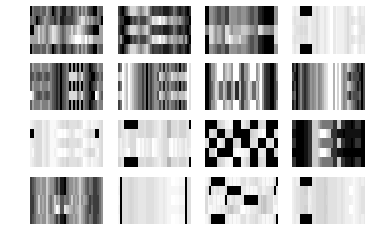

Generated: Notes


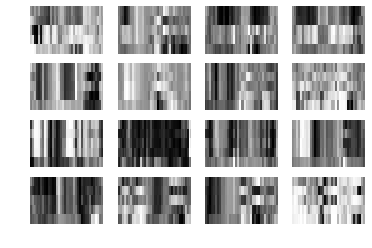

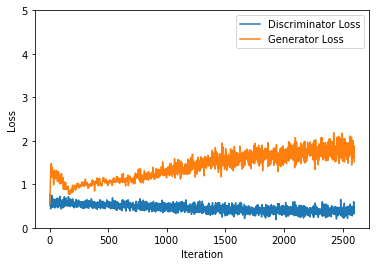

2800 [D loss: 0.250103622674942, acc.: 90.00%] [G loss: 1.8667113780975342]
Real: Notes


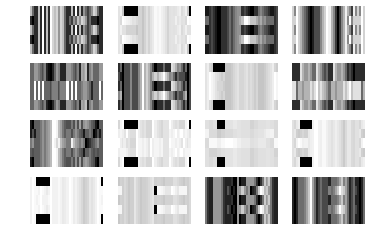

Generated: Notes


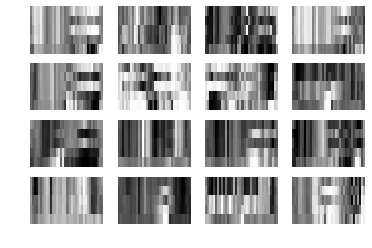

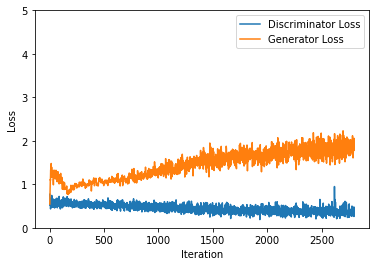

3000 [D loss: 0.43479835987091064, acc.: 78.33%] [G loss: 1.9824023246765137]
Real: Notes


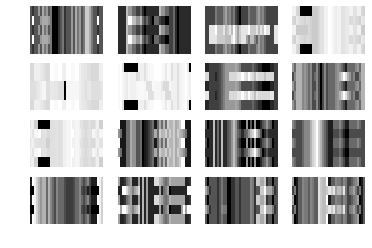

Generated: Notes


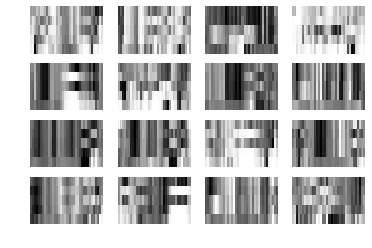

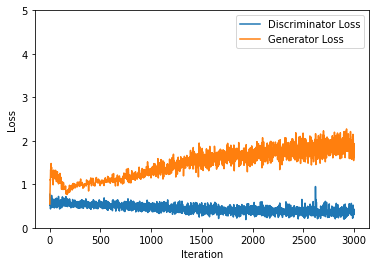

3200 [D loss: 0.3276464343070984, acc.: 86.67%] [G loss: 1.8445557355880737]
Real: Notes


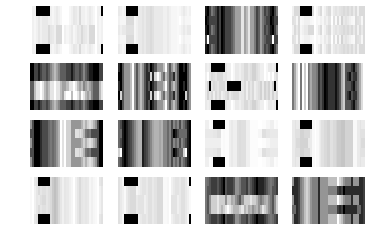

Generated: Notes


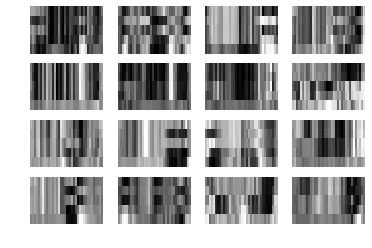

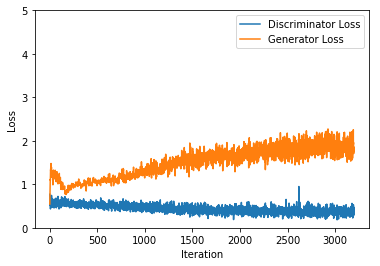

3400 [D loss: 0.4050590991973877, acc.: 81.67%] [G loss: 1.9693067073822021]
Real: Notes


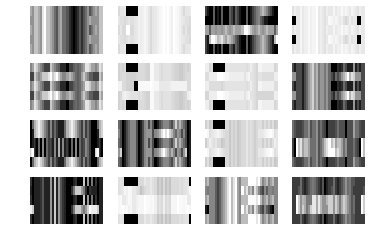

Generated: Notes


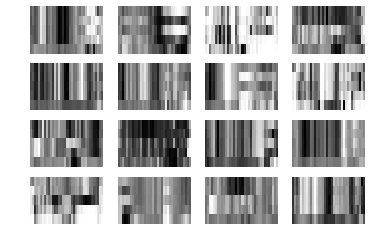

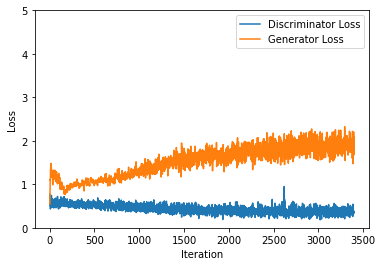

3600 [D loss: 0.37400293350219727, acc.: 83.33%] [G loss: 2.161316394805908]
Real: Notes


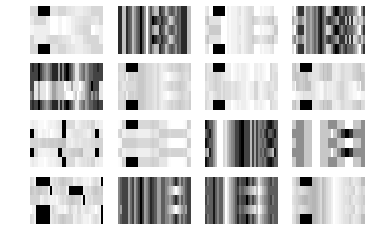

Generated: Notes


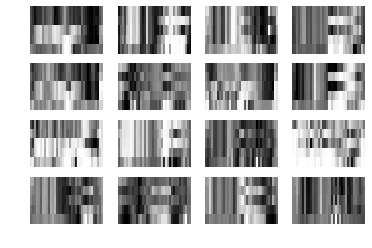

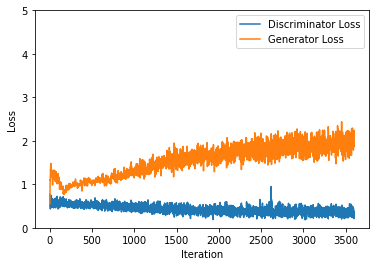

3800 [D loss: 0.28040921688079834, acc.: 86.67%] [G loss: 2.061286449432373]
Real: Notes


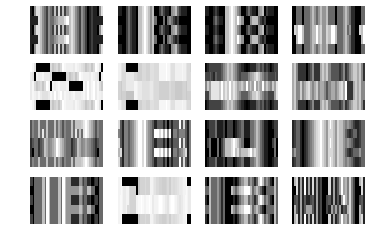

Generated: Notes


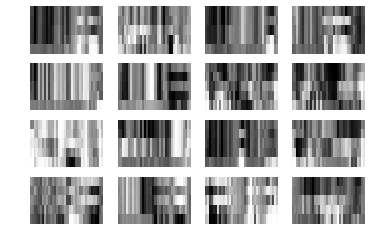

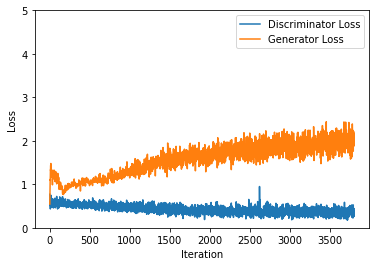

4000 [D loss: 0.375357061624527, acc.: 80.00%] [G loss: 2.0282649993896484]
Real: Notes


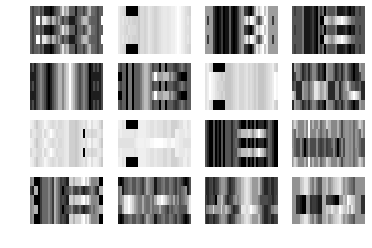

Generated: Notes


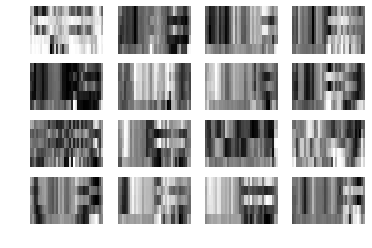

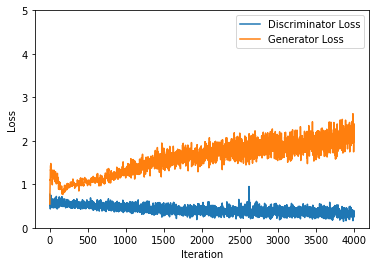

In [0]:
class GAN():
    def __init__(self):
        self.img_dim = [4+1, 64+(4*2)] #RHS of sum is padding
        self.channels = 1
        self.img_shape = [*self.img_dim, self.channels]
        self.noise_shape = [100, ]

        self.gloss = []
        self.dloss = []
        self.intervals = []
        self.graphInterval = 50

        optimizer = optimizers.Adam(0.0002, 0.5)

        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
                                   optimizer=optimizer,
                                   metrics=['accuracy'])

        self.generator = self.build_generator()

        noise = layers.Input(shape=self.noise_shape)
        img = self.generator(noise)

        self.discriminator.trainable = False

        valid = self.discriminator(img)

        self.combined = models.Model(inputs=noise, outputs=valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self, momentum=0.8, alpha_leak=0.2):
        noise_shape = self.noise_shape

        model = models.Sequential()

        model.add(layers.Dense(1024, input_shape=noise_shape))
        model.add(LeakyReLU(alpha=alpha_leak))
        model.add(layers.BatchNormalization(momentum=momentum))
        
        model.add(layers.Dense(64*self.channels*(1+self.img_dim[0]//2)*(self.img_dim[1]//2))) #64 filters, each of half the size of the input image
        model.add(LeakyReLU(alpha=alpha_leak))
        model.add(layers.BatchNormalization(momentum=momentum))
        model.add(layers.Reshape([(1+self.img_dim[0]//2),(self.img_dim[1]//2), 64*self.channels]))
        
        model.add(layers.Conv2DTranspose(32*self.channels, [2,5], padding="same")) #32 filters, each of the size of the input image
        model.add(LeakyReLU(alpha=alpha_leak))
        model.add(layers.BatchNormalization(momentum=momentum))
        model.add(layers.UpSampling2D(size=[2,2])) #now the filters are of the full size of the image, with 1 additional row at the top
        model.add(layers.Cropping2D(cropping=[[1, 0], [0, 0]])) #remove extra padding at the top
        
        model.add(layers.Conv2DTranspose(self.channels, [2,5], padding="same", activation="tanh")) #image

        model.summary()

        noise = layers.Input(shape=noise_shape)
        img = model(noise)

        return models.Model(noise, img)

    def build_discriminator(self, alpha_leak=0.2):
        img_shape = self.img_shape

        model = models.Sequential()

        model.add(layers.Conv2D(32*self.channels, [2,9], strides=[1,1], padding="valid", input_shape=img_shape))
        model.add(layers.Cropping2D(cropping=[[0, 1], [4, 4]]))
        model.add(LeakyReLU(alpha=alpha_leak))
        model.add(layers.Conv2D(64*self.channels, [2,9], strides=[2,2], padding="same"))
        model.add(LeakyReLU(alpha=alpha_leak))
        model.add(layers.Flatten())
        model.add(layers.Dense(1024))
        model.add(LeakyReLU(alpha=alpha_leak))
        model.add(layers.Dense(1, activation="sigmoid"))

        model.summary()

        img = layers.Input(shape=img_shape)
        validity = model(img)

        return models.Model(img, validity)

    def train(self, iterations, batch_size=60, sample_interval=750):
        X_train = np.array(normalizedData)
#         halfMaxPitch = (80+53)//2
#         pitchRange = 80 - halfMaxPitch
#         X_train = (X_train.astype(np.float32) - halfMaxPitch) / pitchRange
#         X_train = np.expand_dims(X_train, axis=3)

        for iteration in range(iterations+1):
            for _ in range(1): #train discriminator more times
              discriminator_loss = self.train_discriminator(X_train, batch_size=batch_size)
              
            generator_loss = self.train_generator(batch_size)

            if(iteration % self.graphInterval):
                self.dloss.append(discriminator_loss[0])
                self.gloss.append(generator_loss)
                self.intervals.append(iteration)

            if iteration % sample_interval == 0:
                print("{} [D loss: {}, acc.: {:.2f}%] [G loss: {}]".format(
                    iteration,
                    discriminator_loss[0],
                    100 * discriminator_loss[1],
                    generator_loss))
                self.sample_images()

        #self.plotLossHistory()

    def train_discriminator(self, X_real, batch_size):
        half_batch = batch_size // 2

        discriminator_indices = np.random.randint(0, X_real.shape[0], half_batch)
        discriminator_train_imgs = X_real[discriminator_indices]

        noise = np.random.normal(0, 1, [half_batch, 100])
        generated_imgs = self.generator.predict(noise)

        discriminator_loss_real = self.discriminator.train_on_batch(discriminator_train_imgs, np.ones([half_batch, 1]))
        discriminator_loss_gen = self.discriminator.train_on_batch(generated_imgs, np.zeros([half_batch, 1]))
        # average the two losses
        discriminator_loss = np.add(discriminator_loss_real, discriminator_loss_gen) / 2

        return discriminator_loss

    def train_generator(self, batch_size):
        noise = np.random.normal(0, 1, [batch_size, 100])
        valid_y = np.array([1] * batch_size)  # move generator towards desired validity

        generator_loss = self.combined.train_on_batch(noise, valid_y)
        return generator_loss
      
    def plotLossHistory(self):
        plt.plot(self.intervals, self.dloss)
        plt.plot(self.intervals, self.gloss)
        plt.legend(["Discriminator Loss", "Generator Loss"])
        plt.xlabel("Iteration")
        plt.ylabel("Loss")
        plt.ylim(ymin=0, ymax=5)
        plt.show()

    def sample_images(self):
          rows, columns = 4, 4
          noise = np.random.normal(0, 1, [rows * columns, 100])

          generated_imgs = self.generator.predict(noise)#[:, :-1, horizontalPad:-horizontalPad,:]
          generated_imgs = 0.5 * generated_imgs + 0.5

          random_real_indices = np.random.randint(0, data.shape[0], rows*columns)
          real_imgs = normalizedData[random_real_indices]#[random_real_indices,:-1, horizontalPad:-horizontalPad, :]
          real_imgs = 0.5 * real_imgs + 0.5

          def prepare_images(images):
            third_channels = np.zeros([images.shape[0], images.shape[1], images.shape[2], 1])
            third_channels[:,:,:,0] = 0
            prepared = np.append(images, third_channels, axis=-1)
            return prepared

          def plotImageGroup(images):
            fig, axs = plt.subplots(rows, columns)
            for row in range(rows):
                for column in range(columns):
                    count = row * columns + column
                    axs[row, column].imshow(images[count], cmap="gray", aspect='auto')
                    axs[row, column].axis('off')

            plt.show()

          #real_imgs, generated_imgs = prepare_images(real_imgs), prepare_images(generated_imgs)

          print("Real: Notes")
          plotImageGroup(real_imgs[:,:,:,0])

          print("Generated: Notes")
          plotImageGroup(generated_imgs[:,:,:,0])

#           print("Real: Timing")
#           plotImageGroup(real_imgs[:,:,:,1])

#           print("Generated: Timing")
#           plotImageGroup(generated_imgs[:,:,:,1])

          self.plotLossHistory()


gan = GAN()
gan.train(iterations=4000, sample_interval=200)

**Save Model**

In [0]:
# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#Save models
gan.combined.save('combined.h5')
gan.generator.save('generator.h5')
gan.discriminator.save('discriminator.h5')

#Upload to GDrive
for fileName in ('combined.h5', 'generator.h5', 'discriminator.h5'):
  uploaded = drive.CreateFile({'title': fileName})
  uploaded.SetContentFile(fileName)
  uploaded.Upload()
  print('Uploaded file {} with ID {}'.format(fileName, uploaded.get('id')))

Uploaded file combined.h5 with ID 10pjJJLrOyBIMIO8tjorqtVFPPSlKLePv
Uploaded file generator.h5 with ID 1RnwY0IluSyIUII1z9zIToDoEGSONPCt-
Uploaded file discriminator.h5 with ID 1ugturgDe_3DwtOhJNa0y0I1wBKCY8mvy


## Post processing

**Generate random samples**

In [0]:
noise = np.random.normal(0, 1, [20, 100]) #20 arrays of noise of shape [100,]
generated_samples = gan.generator.predict(noise)


**Crop out Padding and Reshape into 3D tensor of 16 notes per bar**

In [0]:
generated_samples = generated_samples[:,:-1, 4:-4]
generated_samples = np.squeeze(generated_samples, axis=3) #Remove colour channel
generated_samples = generated_samples.reshape([-1, 16, 16])

**Scale back to Input Range**

In [0]:
generated_samples = scale(generated_samples, minNote, maxNote)

#Make values discrete
#generated_samples = np.around(generated_samples, 0).astype(np.int32)

#Round output values to available values in D major
def samples_to_d_major(samples):
  
  def note_to_d_major(note):
    d_maj_values = np.array([62, 64, 66, 67, 69, 71, 73]) - 60 #C is now at 0
    octave = note // 12
    noteInScale = note % 12

    noteDistances = np.abs(d_maj_values - noteInScale)
    roundedNote = d_maj_values[noteDistances.argmin()]
    return roundedNote + 12*octave
    
  note_to_d_major = np.vectorize(note_to_d_major)
  return note_to_d_major(samples).astype(np.int32)

generated_samples = samples_to_d_major(generated_samples)

print("Shape: {}".format(generated_samples.shape))
print("First 2 scaled samples:")
print(generated_samples[:2])

Shape: (20, 16, 16)
First 2 scaled samples:
[[[66 66 69 69 71 71 69 69 71 71 71 71 71 71 74 74]
  [78 78 78 78 76 76 76 76 69 69 69 69 71 71 71 71]
  [71 71 69 69 69 69 67 67 67 67 67 67 67 67 69 69]
  [64 64 64 64 66 66 67 67 67 67 64 66 64 64 62 62]
  [66 66 69 69 71 71 69 69 71 71 71 71 71 71 74 74]
  [78 78 76 76 74 74 74 74 74 74 74 74 69 69 69 69]
  [69 69 69 69 69 69 67 67 67 67 67 67 66 66 69 69]
  [64 64 64 64 66 66 67 67 67 67 64 64 64 64 62 62]
  [66 66 69 69 69 69 69 69 71 71 71 71 71 71 74 74]
  [78 78 76 76 76 76 74 74 69 69 69 69 71 71 71 71]
  [71 71 69 69 69 69 67 67 67 67 67 67 67 67 67 67]
  [64 64 62 62 66 66 67 67 67 67 66 66 64 64 62 62]
  [64 64 67 67 69 69 69 69 71 71 71 71 71 71 74 74]
  [78 78 76 78 78 78 76 74 76 76 71 71 71 71 67 67]
  [69 71 69 67 69 69 67 67 67 67 67 67 66 66 67 67]
  [66 66 64 64 67 67 67 67 67 67 66 66 64 64 62 62]]

 [[62 62 62 62 64 64 64 64 62 62 64 64 64 64 62 62]
  [59 59 62 62 62 62 62 62 66 66 64 64 62 62 59 62]
  [64 62 62 62 67 

### Save generated samples

In [0]:
np.save("generated_notes.npy", generated_samples)

files = ["generated_notes.npy"]
for file in files:
  uploaded = drive.CreateFile({'title': file})
  uploaded.SetContentFile(file)
  uploaded.Upload()
  print('Uploaded file {} with ID {}'.format(file, uploaded.get('id')))

Uploaded file generated_notes.npy with ID 1UDbVmpC82XryhSsL27OG-dfB3pIeq_vX


In [0]:
# chars_as_num = {
#     'C': 60,
#     'D': 62,
#     'E': 64,
#     'F': 65,
#     'G': 67,
#     'A': 69,
#     'B': 71,
#     'c': 72,
#     'd': 74,
#     'e': 76,
#     'f': 77,
#     'g': 79,
#     'a': 81,
#     'b': 83,
#     'z': 0
# }

# notes = {v:k for (k,v) in chars_as_num.getitems()}

# def nums_to_abc(nums):
#     chars = []
#     for num in nums:
#         if num in notes:
#             chars.append(nums_as_char[num])
#         elif num > 83:
#             apostrophe_count = np.ceil((num - 83) / 7).astype(np.int32)
#             apostrophe_count = np.asscalar(apostrophe_count)
#             chars.append(notes[num - 7*apostrophe_count])
#             chars.extend(["'"] * apostrophe_count)
#         elif num < 60:
#             comma_count = np.ceil((60 - num) / 7).astype(np.int32)
#             comma_count = np.asscalar(comma_count)
#             chars.append(notes[num + 7*comma_count])
#             chars.extend([","] * comma_count)
            
#     return "".join(chars)
  
# def tune_to_abc(tune):
#   bars = [nums_to_abc(bar) for bar in tune]
#   return "|".join(bars)

# tunes = [tune_to_abc(tune) for tune in generated_samples]

# print("First 3 tunes")
# print(tunes[:3])

In [0]:
# import pandas as pd
# df = pd.DataFrame({'tunes': tunes})
# df.to_csv("generated_tunes.csv")

# # Authenticate and create the PyDrive client.
# # This only needs to be done once in a notebook.
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

# uploaded = drive.CreateFile({'title': "generated_tunes.csv"})
# uploaded.SetContentFile("generated_tunes.csv")
# uploaded.Upload()
# print('Uploaded file with ID {}'.format(uploaded.get('id')))